In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from random import sample
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
import gc
import os


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:
state_space=2
obs_space=1
action_space=3
intermediate_dim=16

In [4]:
env = gym.make('MountainCar-v0')


In [5]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,self.input_dim)))
        model.add(Dense(512,activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(256, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(128, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.output_dim, activation = 'linear',kernel_initializer='he_uniform'))
        model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        return model

In [6]:
BATCH_SIZE=64
LEARNING_RATE=1e-5


In [7]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.97, 
                  memory_size = 20000,  C = 5,LEARNING_RATE=1e-5,GAMMA=0.99,EPSILON_MAX=1.0,EPSILON_MIN=0.01,BATCH_SIZE=64):
        
        #self.env = gym.make('CartPole-v0')
        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel(self.states, self.n_actions, self.lr)
        self.positive_rewards_list=[]
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
    def find_positive_rewards(self):
        self.positive_rewards_list=[]
        for i,x in enumerate(self.memory):
            if x[2]>10:
                self.positive_rewards_list.append(i)
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=self.decay_coe
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
        # indices=[]
        # minibatch=[]
        # if(len(self.positive_rewards_list)>10):
        #     indices=random.sample(self.positive_rewards_list,10)
        #     for i in indices:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-10)
        #     random.shuffle(minibatch)            
        #     return minibatch
        # else:
        #     for i in self.positive_rewards_list:
        #         minibatch.append(self.memory[i])
        #     minibatch=minibatch+random.sample(self.memory, self.batch_size-len(self.positive_rewards_list))
        #     random.shuffle(minibatch)            
        #     return minibatch


    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            #X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
           #print(X.shape,"   ",y.shape  )                          
            #loss = self.model.Qpolicy.fit(final_dataset,verbose=0)   
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
           # print(self.model.Qpolicy.predict_on_batch(X))
           #print(X.shape,"   ",y.shape  )                          
            loss=self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            return loss
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [8]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,state_space, intermediate_dim):
    super(Encoder, self).__init__()
    self.input_layer=tf.keras.layers.InputLayer(input_shape=(1,6))
    self.hidden_layer1=tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform',activity_regularizer=tf.keras.regularizers.L1(0.0001)
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=state_space,
      activation=tf.keras.activations.linear,activity_regularizer=tf.keras.regularizers.L1(0.0001)
    )
    
  def call(self, input_features):
    activation0=self.input_layer(input_features)
    activation1 = self.hidden_layer1(activation0)
    #activation1=self.batchnorm_layer1(activation0)
    activation2=self.hidden_layer2(activation1)
    #activation2=self.batchnorm_layer2(activation1)
    return self.output_layer(activation2)

In [9]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.linear
    )
  
  def call(self, inputs):
    input_features=inputs[0]
    var=inputs[1]
    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      # print("1")
      temp=tf.map_fn(lambda x: tf.concat((x[0],x[1]),axis=1),inputs,fn_output_signature=tf.float32)
      # print(temp)
      # temp=[]
      # for i in range(len(input_features)):
      #     temp.append(tf.concat((input_features[i],var[i]),axis=1))
      # temp=tf.convert_to_tensor(temp,dtype=tf.float32)
      activation1 = self.hidden_layer1(temp)
      del temp
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [10]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, state_space,obs_space):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim,state_space=state_space)
    
    self.decoder = Decoder(
      intermediate_dim=intermediate_dim,
      obs_space=obs_space
    )
    
  
  def call(self, inputs):
    input_features=inputs[0]
    var=inputs[1]
    code = self.encoder(input_features)
    #self.var=tf.Variable(var,trainable=False)
    reconstructed = self.decoder([code,var])
    return reconstructed


opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [11]:
def loss(model,input_features, obs,var):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(input_features,var), obs)))
  return reconstruction_error

loss_fn=tf.keras.losses.MeanSquaredError()

@tf.function  
def train( model,input_features,obs,var,opt,loss_fn=loss_fn):
  with tf.GradientTape() as tape:
    output=model([input_features,var])
    loss=tf.reduce_mean(loss_fn(obs,output))
    gradients = tape.gradient(loss, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  return loss

In [12]:
def get_obs(state):
    return [state[0]]

In [13]:
def data_collection_per_eps(env,dqn_solver,autoencoder,maxt=200,upgrade_every=50):

    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0]]))
    O_predicted_series.append(np.array([[0.0]]))
    encoder=autoencoder.encoder
    decoder=autoencoder.decoder
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    i=0
    s0=env.reset()
    s0=s0[0]
    #s0=np.reshape(s0,[1,state_space])
    
    step=0
    done=False
    truncated=False
    for t in range(maxt):
        
        if(step==0):
            s=s0
            #S_actual_series.append(s)
        else:
            s=encoder(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            s=np.reshape(s,(1,state_space))
            # s=s.tolist()
            # s[0][0]=np.tanh(s[0][0])*4.8
            # s[0][2]=np.tanh(s[0][2])*0.418
            # s=np.array(s)
            

        s=np.reshape(s,(1,state_space))
        S_series.append(s)
        #print(S_series,U_series,R_series,S_series,Done_series)
        if((i>0)and (not(step==0))):
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
            loss=dqn_solver.train()
        action=dqn_solver.act(s)

        actual_state, reward, done,truncated,_ = env.step(int(action))
        obs=get_obs(actual_state)
        Done_series.append(done)
        #actual_state=np.reshape(actual_state,[1,state_space])
        #S_actual_series.append(actual_state)
        action=np.array([[action]])
        action=action.astype('float32')
        U_series.append(action)
        obs=np.reshape(obs,[1,obs_space])

        O_series.append(obs)
        # if(reward>10):
        #     dqn_solver.positive_rewards_list.append(i)
        R_series.append(reward)
        # print(s.shape)
        # print(action.shape)
        obs_pred=decoder([s,tf.convert_to_tensor(action)])
        
        obs_pred=np.reshape(obs_pred,[1,obs_space])
        obs_pred=obs_pred.tolist()
        # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
        # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
        obs_pred=np.array(obs_pred)
        O_predicted_series.append(obs_pred)
        i+=1
        step+=1

        # if(t%upgrade_every==0):
        #     dqn_solver.update_target_model()
        #print(env.game_over)
        if(done==True):
            terminal_state_pred=encoder(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
            # print(terminal_state_pred)
            # print(S_series[i-1][0])
            # print(R_series[i-1])
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
            dqn_solver.train()
            break

    
    return S_series,O_series,U_series,R_series,O_predicted_series,Done_series


In [14]:
def data_collection_over_eps(total_episodes,env,dqn_solver,autoencoder,maxt=200):
    main_list=[]
    ep_no=0
    while(ep_no<total_episodes):
        temp=[]
        S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection_per_eps(env,dqn_solver,autoencoder,maxt=200)
        temp.append(S_series)
        temp.append(U_series)
        temp.append(O_series)
        temp.append(R_series)
        temp.append(O_predicted_series)
        main_list.append(temp)
        if(ep_no%5==0):
            print(ep_no)
            dqn_solver.update_target_model()
        dqn_solver.decrement_epsilon()
        ep_no+=1
    return main_list

In [15]:
def autoencoder_training_per_eps(epochs,autoencoder,S_series,O_series,U_series,opt):
    temp1=[]
    temp2=[]
    temp3=[]
    losses=[]
    random_list=[]
    #print(len(S_series))
    if(len(S_series)<15005):
        random_list=list(range(2,len(S_series)-1))
    else:
        random_list=sample(list(range(2,len(S_series)-1)),15000)
    for i in random_list:
        temp1.append(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
        temp2.append(O_series[i+1])
        temp3.append(U_series[i])
    input_features_dataset=tf.data.Dataset.from_tensor_slices(temp1).batch(32,drop_remainder=False)
    O_actual_dataset=tf.data.Dataset.from_tensor_slices(temp2).batch(32,drop_remainder=False)
    var_dataset=tf.data.Dataset.from_tensor_slices(temp3).batch(32,drop_remainder=False)
    final_dataset=tf.data.Dataset.zip((input_features_dataset, O_actual_dataset,var_dataset))

    for epoch in range(epochs):
        for x in final_dataset:
#             if(epoch==0 and i==0):
#                 print("initial loss " ,loss(autoencoder,x[0],x[1],x[2]))
            losses=train(autoencoder,x[0],x[1],x[2],opt)
            #print(losses)
#             if(epoch==(epochs-1) and i==0):
#                 print("final loss ",loss(autoencoder,x[0],x[1],x[2]))
        #time.sleep(0.1)
    #print(losses)
    del temp1
    del temp2
    del temp3
    del final_dataset
    del input_features_dataset
    del var_dataset
    del O_actual_dataset
    gc.collect()
    return losses

In [16]:
def autoencoder_training_over_eps(epochs,autoencoder,main_list,opt):
    S_series=[]
    O_series=[]
    U_series=[]
    for eps in trange(len(main_list),leave=False):
        S_series=main_list[eps][0]
        U_series=main_list[eps][1]
        O_series=main_list[eps][2]
        losses=autoencoder_training_per_eps(epochs,autoencoder,S_series,O_series,U_series,opt)
    print(losses)

In [17]:
def final_loop(total_episodes,dqn_solver,autoencoder,ep_reward_sum_array,maxt=200):

    S_series=[]
    S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0]]))
    O_predicted_series.append(np.array([[0.0]]))
    encoder=autoencoder.encoder
    decoder=autoencoder.decoder
    ep_reward_sum=0
    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        #s0=np.reshape(s0,[1,state_space])
        ep_reward_sum=0
        step=0
        done=False
        for t in range(maxt):
            if(step==0):
                s=s0[0]
                S_actual_series.append(s)
            else:
                s=encoder(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                
            
                
            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            if(i>0):
                #print(i)
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
                loss=dqn_solver.train()
            action=dqn_solver.act(s)

            actual_state, reward, done, info,_ = env.step(int(action))
            S_actual_series.append(actual_state)
            obs=get_obs(actual_state)
            ep_reward_sum+=reward
            Done_series.append(done)
            #actual_state=np.reshape(actual_state,[1,state_space])
            #S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])
            

            O_series.append(obs)
            
            R_series.append(reward)
            obs_pred=decoder([s,tf.convert_to_tensor(action)])
            
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            if(done==True):
                break
        ep_no+=1
        ep_reward_sum_array.append(ep_reward_sum)
        dqn_solver.decrement_epsilon()
        if(ep_no%5==0):
           #print("yay")
           dqn_solver.update_target_model()
        if(ep_no%5==0):
            print(loss,ep_reward_sum,dqn_solver.epsilon) 
    return S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series
   


In [18]:
rewards_storage=[]

In [19]:
def complete_loop(autoencoder,dqn_solver,epochs):
    opt=tf.keras.optimizers.Adam(learning_rate=1e-5)
    flag=0
    complete_eps=50
    for epoch in range(epochs):
        reward_sum=0
        # no_positive_rewards=0
        # no_100_rewards=0
        # for reward in R_series:
        #     if(reward>10):
        #         no_positive_rewards+=1
        #     if(reward>99):
        #         no_100_rewards+=1
        # print(no_positive_rewards,no_100_rewards)
        if(epoch<epochs-1):
            main_list=data_collection_over_eps(complete_eps,env,dqn_solver,autoencoder)
            for x in main_list:
                reward_sum+=sum(x[3])
            print("epoch: {}, epsilon {}, reward:{}".format(epoch, dqn_solver.epsilon, reward_sum))
        # print("epoch: {}, total reward: {}, number of steps: {}, epsilon {}".format(epoch, sum(R_series),len(S_series),dqn_solver.epsilon))
            rewards_storage.append(reward_sum)
            aenc_epochs=max(10,int(np.tanh(epoch/10)*50))
            autoencoder_training_over_eps(aenc_epochs,autoencoder,main_list,opt)
            dqn_solver.epsilon=1.0
            dqn_solver.forget()
            del main_list
            
        else:
            if epoch==epochs-1:
                autoencoder.save_weights('aenc_weights_mountain_car')
                dqn_solver.epsilon=1.0
                dqn_solver.decay_coe=0.998
                
            S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series=final_loop(5000,dqn_solver,autoencoder,rewards_storage,maxt=200)

        
        gc.collect()
    return  S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series


In [20]:
autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  state_space=state_space,obs_space=obs_space
)

In [21]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


In [ ]:
S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series=complete_loop(autoencoder,dqn_solver,6)

0
5
10
15
20
25
30
35
40
45
epoch: 0, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(0.0044551734, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 1, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(0.14197272, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 2, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(0.03637167, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 3, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(0.0015048818, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 4, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(0.0055773584, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 5, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(0.0012816016, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 6, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(0.0035037487, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 7, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(1.2002123e-05, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 8, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(0.00011700743, shape=(), dtype=float32)
0
5
10
15
20
25
30
35
40
45
epoch: 9, epsilon 0.21806537534740741, reward:-10000.0


tf.Tensor(4.2157375e-05, shape=(), dtype=float32)
{'loss': 0.006314034573733807, 'accuracy': 0.328125} -200.0 0.990039920079968
{'loss': 0.004050193354487419, 'accuracy': 0.6875} -200.0 0.9801790433519495
{'loss': 0.011240331456065178, 'accuracy': 0.421875} -200.0 0.9704163817442236
{'loss': 0.013228904455900192, 'accuracy': 0.609375} -200.0 0.9607509570263429
{'loss': 0.0729459747672081, 'accuracy': 0.328125} -200.0 0.9511818007111134
{'loss': 0.09067157655954361, 'accuracy': 0.390625} -200.0 0.9417079539575507
{'loss': 0.004541502334177494, 'accuracy': 0.59375} -200.0 0.9323284674748037
{'loss': 0.03644909709692001, 'accuracy': 0.375} -200.0 0.9230424014270336
{'loss': 0.20537947118282318, 'accuracy': 0.390625} -200.0 0.913848825339242
{'loss': 0.043328166007995605, 'accuracy': 0.375} -200.0 0.9047468180040359
{'loss': 0.03843116760253906, 'accuracy': 0.703125} -200.0 0.8957354673893211
{'loss': 0.23448945581912994, 'accuracy': 0.765625} -200.0 0.8868138705469162
{'loss': 0.015738032

: 

: 

In [1]:
autoencoder

NameError: name 'autoencoder' is not defined

In [ ]:
dqn_solver.model.Qpolicy.weights

[<tf.Variable 'dense_6/kernel:0' shape=(2, 512) dtype=float32, numpy=
 array([[-1.3499904 ,  0.89110875, -0.85058945, ...,  0.71757776,
         -0.36336818,  0.6449452 ],
        [-1.3579429 ,  1.377162  , -0.5567119 , ..., -1.2358421 ,
         -1.5840187 , -0.4903132 ]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(512,) dtype=float32, numpy=
 array([-0.4335866 , -0.5045786 , -0.31620425,  0.1608362 ,  0.28576022,
        -0.42363662,  0.39186633, -0.5077294 , -0.20187928,  0.268827  ,
        -0.03718115,  0.00862321, -0.4230762 ,  0.25631204, -0.42003068,
        -0.5113473 ,  0.36950883,  0.24798533,  0.30252862,  0.18004929,
         0.39930087,  0.36142686, -0.17756006, -0.4573313 ,  0.33046976,
         0.35246813,  0.291647  ,  0.07572651, -0.13884881, -0.49108765,
         0.06954499, -0.35315982, -0.27826914,  0.12381998, -0.1758795 ,
         0.37809876,  0.32960495, -0.419073  ,  0.01657037, -0.25320816,
         0.23272787,  0.3587581 , -0.25168273, -0.05296683

In [ ]:
autoencoder.weights

[<tf.Variable 'encoder/dense/kernel:0' shape=(4, 16) dtype=float32, numpy=
 array([[ 0.40064022, -1.1326022 , -0.5222728 , -0.6089285 , -0.97210526,
         -0.2250031 , -0.16574831, -0.4843286 , -0.85551184, -0.97219676,
         -0.29821166, -1.1171988 , -0.80586606,  0.5771063 , -1.0669187 ,
         -0.38609314],
        [-0.05009323,  0.0291357 , -0.56287116, -0.11936703, -1.1239035 ,
          0.80778134, -0.7349875 ,  1.2092493 , -1.1172122 ,  0.6040447 ,
         -1.0968972 , -0.64529186,  0.57174546, -0.47803792, -0.45205212,
         -0.03269482],
        [-1.2470943 , -0.06741393, -0.6023927 , -0.74803644,  0.20530678,
          0.9354365 , -0.27244088,  0.5558332 ,  0.10325296,  0.9893822 ,
          0.12245417, -0.29172018, -0.94694364, -0.70428234, -0.31928128,
          0.6897305 ],
        [ 0.63433725, -1.0492492 ,  0.29597908, -0.25355414, -0.04912878,
          0.90731686,  1.0219547 ,  0.8451116 ,  0.8015623 ,  0.93353045,
          0.2219051 , -0.9110855 ,  0.2061

In [ ]:
dqn_solver.epsilon=1.0
dqn_solver.decay_coe=0.99

final_loop(3500,dqn_solver,autoencoder,rewards_storage,maxt=200)


None -200.0 0.9509900498999999
None -200.0 0.9043820750088043
None -200.0 0.8600583546412883
None -200.0 0.8179069375972307
None -200.0 0.7778213593991465
None -200.0 0.7397003733882802
None -200.0 0.7034476949995692
None -200.0 0.6689717585696803
None -200.0 0.6361854860638709
None -200.0 0.6050060671375365
None -200.0 0.5753547499769285
None -200.0 0.5471566423907612
None -200.0 0.5203405226503064
None -200.0 0.49483865960020695
None -200.0 0.47058664158564995
None -200.0 0.44752321376381066
None -200.0 0.42559012338865465
None -200.0 0.4047319726783239
None -200.0 0.3848960788934847
None -200.0 0.36603234127322926
None -200.0 0.34809311449244207
None -200.0 0.33103308832101386
None -200.0 0.31480917318095203
None -200.0 0.29938039131233124
None -200.0 0.2847077732731954
None -200.0 0.270754259511994
None -200.0 0.2574846067639487
None -200.0 0.24486529903492946
None -200.0 0.232864462948006
None -200.0 0.22145178723886094
None -200.0 0.21059844619672854
None -200.0 0.200277026857489

KeyboardInterrupt: 

In [52]:
dqn_solver_new=DQNSolver(state_space=state_space,action_space=action_space)


In [53]:
rewards_storage

[-10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,

In [54]:
dqn_solver_new.epsilon=1.0
dqn_solver_new.decay_coe=0.998

In [55]:
rewards_storage_2=[]

In [40]:
S_series,O_series,U_series,R_series,O_predicted_series,Done_series,S_actual_series=final_loop(4000,dqn_solver_new,autoencoder,rewards_storage_2,maxt=200)

{'loss': 0.07498134672641754, 'accuracy': 0.65625} -200.0 0.9752487531218751
{'loss': 0.044705383479595184, 'accuracy': 0.4375} -200.0 0.9511101304657719
{'loss': 0.017788400873541832, 'accuracy': 0.625} -200.0 0.9275689688183278
{'loss': 0.02552073821425438, 'accuracy': 0.453125} -200.0 0.9046104802746175
{'loss': 0.008592735975980759, 'accuracy': 0.734375} -200.0 0.8822202429488013
{'loss': 0.03334559500217438, 'accuracy': 0.703125} -200.0 0.8603841919146962
{'loss': 0.008511342108249664, 'accuracy': 0.765625} -200.0 0.8390886103705794
{'loss': 0.006511778105050325, 'accuracy': 0.703125} -200.0 0.8183201210226743
{'loss': 0.06928083300590515, 'accuracy': 0.4375} -200.0 0.798065677681905
{'loss': 0.13791155815124512, 'accuracy': 0.640625} -200.0 0.778312557068642
{'loss': 0.005256058182567358, 'accuracy': 0.671875} -200.0 0.7590483508202912
{'loss': 0.03313335031270981, 'accuracy': 0.546875} -200.0 0.7402609576967045
{'loss': 0.00701043801382184, 'accuracy': 0.6875} -200.0 0.721938575

In [57]:
S_series

[array([[-0.5893346,  0.       ]], dtype=float32),
 array([[2.3734353, 1.296255 ]], dtype=float32),
 array([[2.0167484, 1.1894084]], dtype=float32),
 array([[1.8938786, 1.1457711]], dtype=float32),
 array([[1.8529512, 1.1362201]], dtype=float32),
 array([[1.836855 , 1.1345091]], dtype=float32),
 array([[1.8284453, 1.134996 ]], dtype=float32),
 array([[1.2230706, 0.4781581]], dtype=float32),
 array([[2.362698 , 1.7753708]], dtype=float32),
 array([[2.5792847, 2.0103805]], dtype=float32),
 array([[2.61685  , 2.0636535]], dtype=float32),
 array([[1.4105785, 0.7742211]], dtype=float32),
 array([[2.3704429, 1.8056371]], dtype=float32),
 array([[2.555615 , 2.0286348]], dtype=float32),
 array([[2.5823913, 2.0752177]], dtype=float32),
 array([[1.371687 , 0.7891843]], dtype=float32),
 array([[1.6616106, 1.0725117]], dtype=float32),
 array([[1.1142757, 0.4858022]], dtype=float32),
 array([[1.6014231, 1.0264775]], dtype=float32),
 array([[1.086767  , 0.47586536]], dtype=float32),
 array([[1.58449

In [24]:
plt.rcParams['figure.figsize']=[20,10]

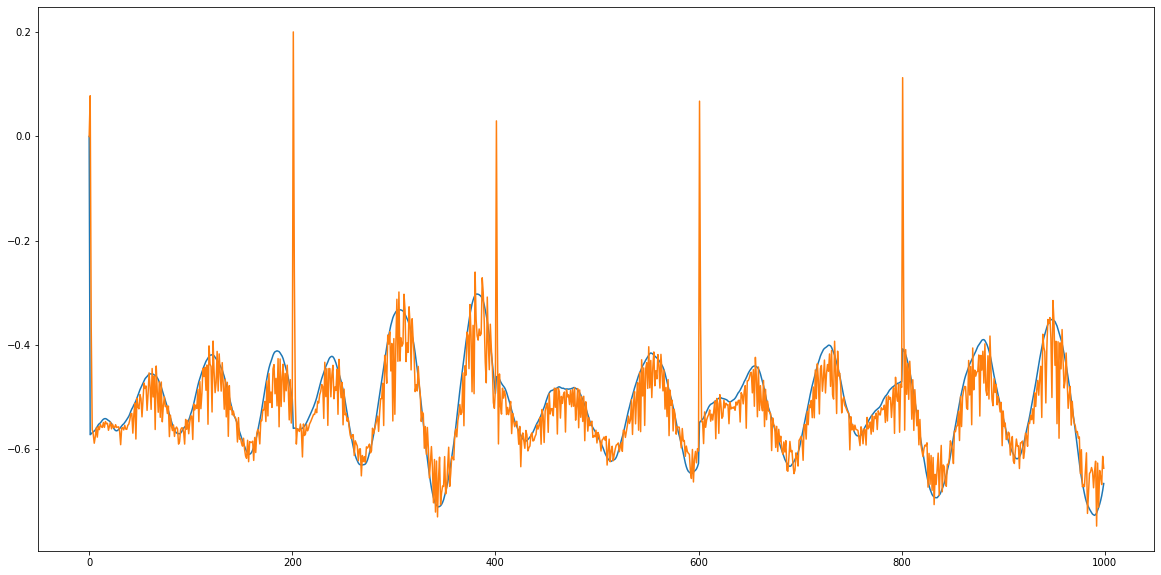

In [25]:
t1=[x[0][0] for x in O_series[0:1000]]
t2=[x[0][0] for x in O_predicted_series[0:1000]]
plt.plot(t1)
plt.plot(t2)

In [62]:
S_actual_series

[array([-0.5893346,  0.       ], dtype=float32),
 array([-0.5878448 ,  0.00148983], dtype=float32),
 array([-0.5858761,  0.0019687], dtype=float32),
 array([-0.58344305,  0.00243306], dtype=float32),
 array([-0.58056355,  0.00287949], dtype=float32),
 array([-0.5772589 ,  0.00330465], dtype=float32),
 array([-0.57355356,  0.00370536], dtype=float32),
 array([-0.5704749 ,  0.00307862], dtype=float32),
 array([-0.5660459 ,  0.00442904], dtype=float32),
 array([-0.56029934,  0.00574653], dtype=float32),
 array([-0.55327815,  0.00702123], dtype=float32),
 array([-0.54703456,  0.00624353], dtype=float32),
 array([-0.53961545,  0.00741915], dtype=float32),
 array([-0.5310762 ,  0.00853923], dtype=float32),
 array([-0.5214809 ,  0.00959531], dtype=float32),
 array([-0.5129015 ,  0.00857942], dtype=float32),
 array([-0.5044023 ,  0.00849921], dtype=float32),
 array([-0.49704695,  0.00735531], dtype=float32),
 array([-0.48989058,  0.00715639], dtype=float32),
 array([-0.48398656,  0.005904  ], 

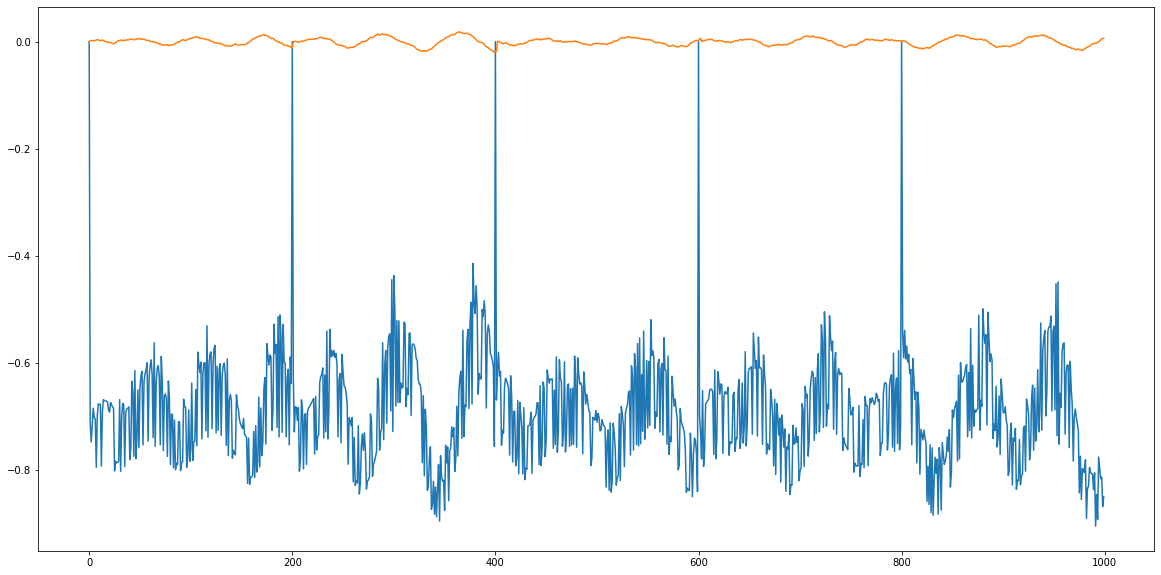

In [28]:
t1=[x[0][1] for x in S_series[0:1000]]
t2=[x[1] for x in S_actual_series[0:1000]]
plt.plot(t1)
plt.plot(t2)

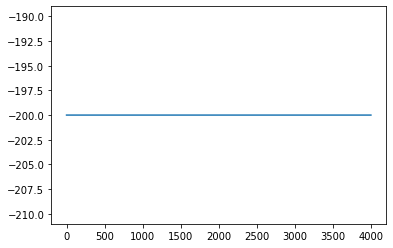

In [50]:
plt.plot(rewards_storage_2)